In [8]:
from pyprojroot import here
import pandas as pd
import numpy as np

In [15]:
# read the data
weather_path = here("data/raw/WTH.csv")
df = pd.read_csv(weather_path)
# convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date']) 

df_y = df[["WindSpeed"]] # separate target to be able to perform MV input, Univariate output  
print("Target shape:", df_y.shape)

# df = df.set_index("date")
print("df shape:", df.shape)
print(df.columns)

Target shape: (35064, 1)
df shape: (35064, 13)
Index(['date', 'Visibility', 'DryBulbFarenheit', 'DryBulbCelsius',
       'WetBulbFarenheit', 'DewPointFarenheit', 'DewPointCelsius',
       'RelativeHumidity', 'WindSpeed', 'WindDirection', 'StationPressure',
       'Altimeter', 'WetBulbCelsius'],
      dtype='object')


<Axes: >

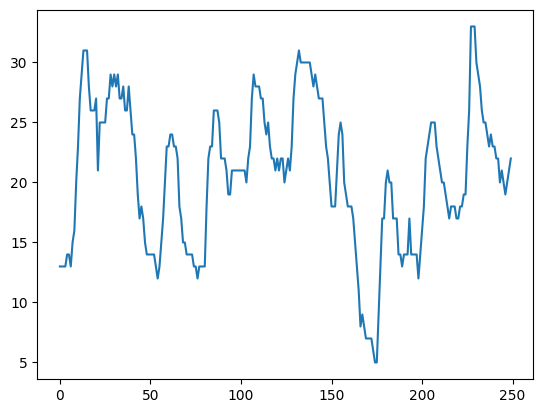

In [13]:
df["WetBulbFarenheit"][:250].plot()

<Axes: >

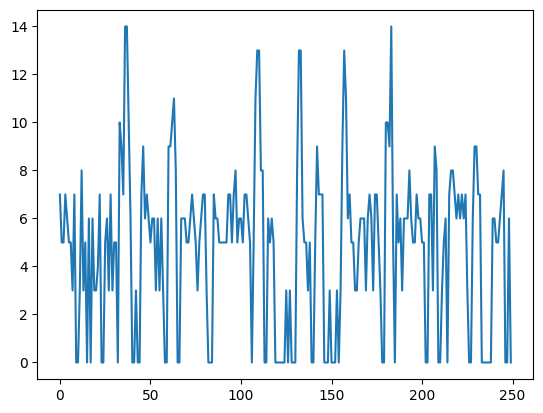

In [14]:
df["WindSpeed"][:250].plot()

In [16]:
flag = "test"
type_map = {'train': 0, 'val': 1, 'test': 2}
set_type = type_map[flag]

seq_len = 168
label_len = 24
pred_len = 12

border1s = [0, 12 * 30 * 24 - seq_len,
                    12 * 30 * 24 + 4 * 30 * 24 - seq_len]
border2s = [12 * 30 * 24, 12 * 30 * 24 +
            4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]
border1 = border1s[set_type]
border2 = border2s[set_type]

cols_data = df.columns[1:] # remove date column
df_data = df[cols_data] # take all the columns axcept date
data = df_data.values # convert to numpy
data_y = df_y.values
print("Numpy array shape:", data.shape)

Numpy array shape: (35064, 12)


In [17]:
df_stamp = df[['date']][border1:border2]
print("df_stamp shape", df_stamp.shape)
df_stamp['date'] = pd.to_datetime(df_stamp.date) # convert date to date_time

df_stamp shape (3048, 1)


In [21]:
# First approach: compute 4 time related features and return a numpy array
df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
df_stamp['weekday'] = df_stamp.date.apply(
    lambda row: row.weekday(), 1)
df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
data_stamp = df_stamp.drop(columns=['date'])
data_stamp = data_stamp.values # convert to numpy
print("data_stamp shape:", data_stamp.shape)
# data_stamp.head(5)

data_stamp shape: (3048, 4)


In [47]:
# second approach: compute 4 time related features and return a numpy array
# from timefeatures import time_features
# freq='h'
# data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=freq)
# print("data_stamp shape:", data_stamp.shape)
# data_stamp = data_stamp.transpose(1, 0) # switch axis
# print("data_stamp shape:", data_stamp.shape)

data_stamp shape: (4, 3048)
data_stamp shape: (3048, 4)


In [23]:
# cut to the size of the given flag: train, valid, or test
data_x = data[border1:border2]
data_y = data[border1:border2]
data_stamp = data_stamp
print('data_x shape', data_x.shape, 'data_y shape', data_y.shape, 'data_stamp shape', data_stamp.shape)

data_x shape (3048, 12) data_y shape (3048, 12) data_stamp shape (3048, 4)


lookback/windowsize: 168 == seq_len
horizon = 24 == pred_len
label_len: 48 + 24 = 72 

In [25]:
length = len(data_x) - seq_len - pred_len + 1
print("Total length that can be converted into a sequential data:", length)
def get_data(data_x, data_y, data_stamp, seq_len, label_len, pred_len):
    for i in range(length):
        s_begin = i
        s_end = s_begin + seq_len
        r_begin = s_end - label_len
        r_end = r_begin + label_len + pred_len

        seq_x = data_x[s_begin:s_end]
        seq_y = data_y[r_begin:r_end]
        seq_x_mark = data_stamp[s_begin:s_end]
        seq_y_mark = data_stamp[r_begin:r_end]
        if i == 0:
            seq_x_full = seq_x[np.newaxis, :]
            seq_y_full = seq_y[np.newaxis, :]
            seq_x_mark_full = seq_x_mark[np.newaxis, :]
            seq_y_mark_full = seq_y_mark[np.newaxis, :]
        else:
            seq_x_full = np.concatenate([seq_x_full, seq_x[np.newaxis, :]], axis=0)
            seq_y_full = np.concatenate([seq_y_full, seq_y[np.newaxis, :]], axis=0)
            seq_x_mark_full = np.concatenate([seq_x_mark_full, seq_x_mark[np.newaxis, :]], axis=0)
            seq_y_mark_full = np.concatenate([seq_y_mark_full, seq_y_mark[np.newaxis, :]], axis=0)

    return seq_x_full, seq_y_full, seq_x_mark_full, seq_y_mark_full

Total length that can be converted into a sequential data: 2869


In [26]:
seq_x, seq_y, seq_x_mark, seq_y_mark = get_data(data_x, data_y, data_stamp, seq_len, label_len, pred_len)

In [30]:
# seq_len

# label_len
pred_len

12

In [ ]:
(3048, 12)

In [27]:
print('seq_x shape', seq_x.shape, 'seq_y shape', seq_y.shape, 'seq_x_mark shape', seq_x_mark.shape, 'seq_y_mark shape', seq_y_mark.shape)

seq_x shape (2869, 168, 12) seq_y shape (2869, 36, 12) seq_x_mark shape (2869, 168, 4) seq_y_mark shape (2869, 36, 4)
